In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import pandas as pd

### Parameters

In [2]:
n_x = n_y = 4 # Size of the auditory space
n_sounds = 4 # Number od sounds in each sequence
n_categories = 3 # Number of category

In [3]:
space = np.zeros((n_x, n_y)) # Space is a square matrix
space

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

In [4]:
cmap = matplotlib.cm.get_cmap('Set1')
norm = matplotlib.colors.Normalize(vmin=0, vmax=1)

In [5]:
bloc_type_colors = {
    'training': cmap(norm(0)),
    'generalization': cmap(norm(.2))
}
bloc_type_cmaps = {
    'training': matplotlib.cm.get_cmap('Reds'),
    'generalization': matplotlib.cm.get_cmap('Blues')
}
win_size = 8

In [6]:
labels = np.array(['zorro', 'butterfly', 'square'])
labels_names = np.array(['z', 'b', 's'])
n_labels = labels.size

### Choose basic shapes

In [7]:
# Array of category templates
# Sequence are represented as a 3D matrix of size n_sounds x n_x x n_y
templates = np.zeros((n_categories, n_sounds, n_x, n_y))
category_names = ['zorro', 'butterfly', 'square']

In [8]:
# Zorro shape (in x --> AABB)
templates[0][0, 0, 0] = 1
templates[0][1, 0, 1] = 1
templates[0][2, 1, 0] = 1
templates[0][3, 1, 1] = 1

In [9]:
# Butterfly shape (in x --> ABAB)
templates[1][0, 0, 0] = 1
templates[1][1, 1, 1] = 1
templates[1][2, 0, 1] = 1
templates[1][3, 1, 0] = 1

In [10]:
# Square shape (in x --> ABBA)
templates[2][0, 0, 0] = 1
templates[2][1, 1, 0] = 1
templates[2][2, 1, 1] = 1
templates[2][3, 0, 1] = 1

### Load data

In [11]:
dname = os.getcwd() + '/../../sequences/'

In [12]:
n_categories, _, _, n_sounds, n_x, n_y = np.load(dname + 'basic.npy').shape

In [13]:
sequences_dict = {
    r'$\emptyset$': np.load(dname + 'basic.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$|$': np.load(dname + 'mirror_x.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$—$': np.load(dname + 'mirror_y.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$| + —$': np.load(dname + 'rot_pi.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\curvearrowleft$': np.load(dname + 'rot_minus_pi_2.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\curvearrowright$': np.load(dname + 'rot_pi_2.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\curvearrowright + |$': np.load(dname + 'rot_pi_2_mirror_x.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\curvearrowright + —$': np.load(dname + 'rot_pi_2_mirror_y.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\bigstar$': np.load(dname + 'extra.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\bigstar + |$': np.load(dname + 'extra_mirror_x.npy').reshape(n_categories, -1, n_sounds, n_x, n_y),
    r'$\bigstar + —$': np.load(dname + 'extra_mirror_y.npy').reshape(n_categories, -1, n_sounds, n_x, n_y)
}
trial_types = sequences_dict.keys()
n_trial_types = len(trial_types)
n_trial_types

11

### Declare model

In [14]:
class InferenceModelBase():
    '''
    Inference model that attributes a category to temporal sequences.
    ...

    Attributes
    ----------
    None

    Methods
    -------
    infer_category(sequence):
        Infer the category of a sequence.
    '''
    
    import numpy as np
    
    def __init__(self, templates):
        '''
        Initiate model parameters.

        Parameters
        ----------
            repr_format : str
                the format of the internal representations of the model
            templates : numpy array
                the category template with size n_categories x n_sounds x n_x x n_y
        '''
        # Complete original templates
        self.templates = templates.copy()
        self.n_categories = templates.shape[0]
        self.n_sounds = templates.shape[1]
        self.n_x = templates.shape[2]
        self.n_y = templates.shape[3]
        
        # Compute internal representation of templates
        self.templates_repr = []
        for template in self.templates:
            template_repr = self._internal_repr(template)
            self.templates_repr.append(template_repr)
        self.templates_repr = np.array(self.templates_repr)
 
    def infer_category(self, sequence, beta=1):
        '''
        Infer the category of a sequence given the model's internal representations.
        
        Parameters
        ----------
        sequence : numpy array
            the input sequence to represent
        beta : float
            the inverse temperature parameter of the softmax for choice probabilities
            
        Returns
        -------
        similarity_values : numpy array
            the unormalized similarity score for each category
        probs : numpy array
            a probability of choice for each category
        '''
        # Compute the internal representation of the sequence 
        sequence_repr = self._internal_repr(sequence)
        
        # Evaluate similarity between:
        # 1. Internal representations of category
        # 2 .Internal representations of input sequence
        similarity_values = []
        for template_repr in self.templates_repr:
            similarity_value = self._compute_similarity(sequence_repr, template_repr)
            similarity_values.append(similarity_value)
        similarity_values = np.array(similarity_values)
            
        # Apply softmax to convert unomalized values into choice probabilities
        probs = np.exp(similarity_values/beta)/np.sum(np.exp(similarity_values/beta))
        
        # Return 
        return similarity_values, probs

    def _compute_similarity(self, repr_1, repr_2):
        '''
        Compute the similarity between two representations (two tensors).
        
        Parameters
        ----------
        repr_1 : numpy array
            the first representation to compare
        repr_2 : numpy array
            the second representation to compare
            
        Returns
        -------
        score : numpy array
            the similarity score between the the two representations
        '''
        # Muliply representations together 
        repr_multi = 1./(np.linalg.norm(repr_1 - repr_2) + 0.1)
        
        # Sum
        similarity_score = np.sum(repr_multi)
        
        # Return
        return similarity_score
        
    def _internal_repr(self, sequence):
        '''
        Return the internal represention of a given sequence.
        
        Parameters
        ----------
            sequence : numpy array
                the format of the internal representations of the model
        '''
        return sequence

### Model 2D

In [15]:
def angle(v0, v1):
    v0 = v0 / np.linalg.norm(v0)
    v1 = v1 / np.linalg.norm(v1)
    return np.math.atan2(np.linalg.det([v0, v1]), np.dot(v0, v1))

In [16]:
class InferenceModel2D(InferenceModelBase):
    def _internal_repr(self, sequence):
        vec = np.array([np.diff(np.where(sequence)[1]), np.diff(np.where(sequence)[2])]).T
        angles = np.array([angle(vec[0], vec[1]), angle(vec[1], vec[2])])
        if angles[0] > 0: angles *= -1
        return angles

### Model 1Dx

In [17]:
class InferenceModel1Dx(InferenceModelBase):
    def _internal_repr(self, sequence):
        proj_x = np.sum(sequence, axis=1)
        pattern = np.unique(proj_x, axis=0, return_inverse=True)[1]
        if pattern[0] != 0: pattern = np.array(np.logical_not(pattern), dtype=int) # Always start with "0"
        return pattern

### Model 1Dy

In [18]:
class InferenceModel1Dy(InferenceModelBase):
    def _internal_repr(self, sequence):
        proj_y = np.sum(sequence, axis=2)
        pattern = np.unique(proj_y, axis=0, return_inverse=True)[1]
        if pattern[0] != 0: pattern = np.array(np.logical_not(pattern), dtype=int) # Always start with "0"
        return pattern

In [19]:
# Declare model
model = InferenceModel1Dx(templates)

# Declare confusion matrix of this model 
n_translations = sequences_dict[r'$\emptyset$'][0].shape[0]
CONFUSION_MATRIX = np.zeros((n_trial_types, n_translations, n_categories, n_categories))

# Run the model on all sequences and all generalization types
for i, trial_type in enumerate(trial_types):
    for j, category_name in enumerate(category_names):
        for k, sequence in enumerate(sequences_dict[trial_type][j]):
            
            # Compute model (probability) of choice
            p = model.infer_category(sequence, beta=0.1)[1]
            
            # Add to the confusion matrix
            CONFUSION_MATRIX[i, k, j] = p

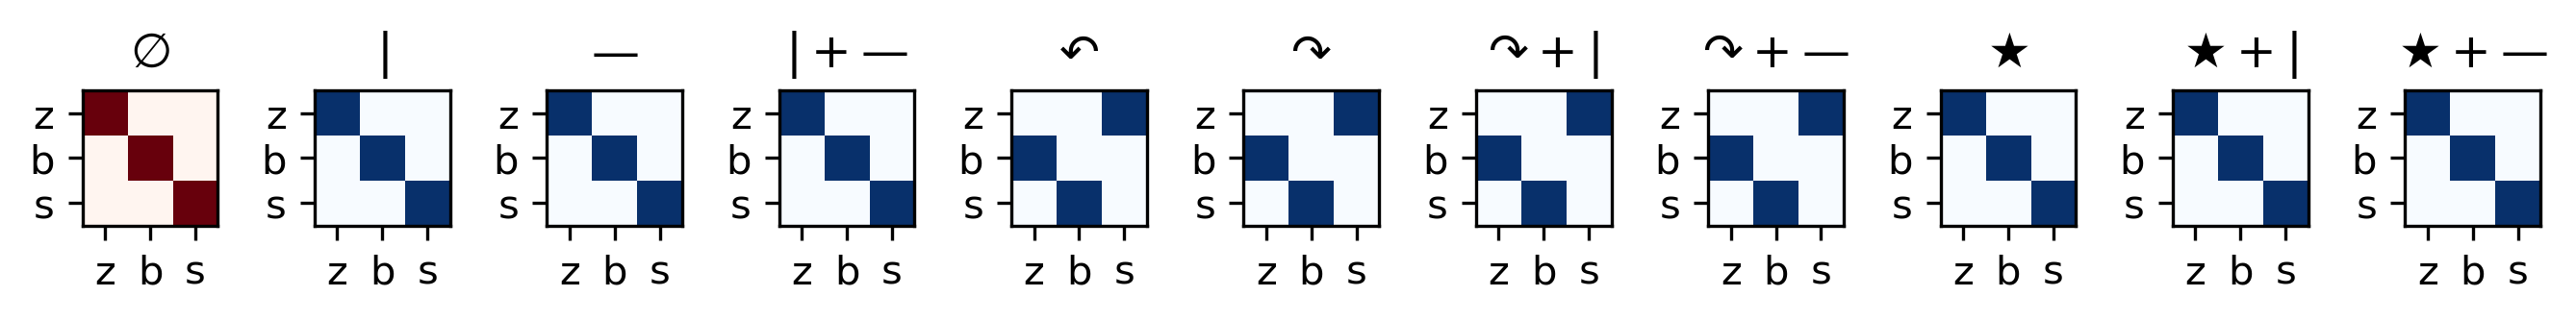

In [20]:
# Prepare figure
fig, axs = plt.subplots(1, n_trial_types, figsize=(9, 1), dpi=300, facecolor='w')

for i, (ax, trial_type) in enumerate(zip(axs, trial_types)):

    # Get colormap
    cmap = bloc_type_cmaps['training'] if trial_type == r'$\emptyset$' else bloc_type_cmaps['generalization']

    # Compute confution matrix
    m = np.mean(CONFUSION_MATRIX[i], axis=0)

    # Plot matrix
    ax.imshow(m, vmin=0, vmax=1, cmap=cmap)
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(labels_names)
    ax.set_yticklabels(labels_names)
    ax.set_title(trial_type, fontweight='bold')

plt.tight_layout()
fig.savefig('figures/fig_1a.png')

### All models

In [21]:
def returnConfusionMatrix(model):

    # Declare confusion matrix of this model 
    n_translations = sequences_dict[r'$\emptyset$'][0].shape[0]
    CONFUSION_MATRIX = np.zeros((n_trial_types, n_translations, n_categories, n_categories))

    # Run the model on all sequences and all generalization types
    for i, trial_type in enumerate(trial_types):
        for j, category_name in enumerate(category_names):
            for k, sequence in enumerate(sequences_dict[trial_type][j]):

                # Compute model (probability) of choice
                p = model.infer_category(sequence, beta=0.1)[1]

                # Add to the confusion matrix
                CONFUSION_MATRIX[i, k, j] = p
    
    # Return
    return np.mean(CONFUSION_MATRIX, axis=1)

In [22]:
n_models = 12 # Random, No generalization, 1Dx, 1Dxextrarotx, 1Dxextraroty, 1Dxnoextra, 1Dy, 1Dyextrarotx, 1Dyextraroty, 1Dynoextra, 2D, 2Dnoextra
model_names = np.array([
    'No learn.', 
    'No gen.', 
    '1Dx$\\bigstar$', 
    '1Dx$\\bigstar$x', 
    '1Dx$\\bigstar$y', 
    '1Dx', 
    '1Dy$\\bigstar$', 
    '1Dy$\\bigstar$x', 
    '1Dy$\\bigstar$y', 
    '1Dy', 
    '2D$\\bigstar$', 
    '2D'
])
CONFUSION_MATRIX_MODELS = np.zeros((n_models, n_trial_types, n_categories, n_categories))

# Random
CONFUSION_MATRIX_MODELS[0] = 1./n_categories

# Random
model = InferenceModel1Dx(templates)
CONFUSION_MATRIX_MODELS[1] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[1][1:] = 1./n_categories

# 1Dx
model = InferenceModel1Dx(templates)
CONFUSION_MATRIX_MODELS[2] = returnConfusionMatrix(model)

# 1Dxextrarotx
model = InferenceModel1Dx(templates)
CONFUSION_MATRIX_MODELS[3] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[3][8:] = CONFUSION_MATRIX_MODELS[3][4]

# 1Dxextraroty
model = InferenceModel1Dx(templates)
CONFUSION_MATRIX_MODELS[4] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[4][8:] = returnConfusionMatrix(InferenceModel1Dy(templates))[4]

# 1Dxnoextra
model = InferenceModel1Dx(templates)
CONFUSION_MATRIX_MODELS[5] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[5][8:] = 0.33

# 1Dy
model = InferenceModel1Dy(templates)
CONFUSION_MATRIX_MODELS[6] = returnConfusionMatrix(model)

# 1Dyextrarotx
model = InferenceModel1Dy(templates)
CONFUSION_MATRIX_MODELS[7] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[7][8:] = CONFUSION_MATRIX_MODELS[3][4]

# 1Dyextraroty
model = InferenceModel1Dy(templates)
CONFUSION_MATRIX_MODELS[8] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[8][8:] = returnConfusionMatrix(InferenceModel1Dx(templates))[4]

# 1Dynoextra
model = InferenceModel1Dy(templates)
CONFUSION_MATRIX_MODELS[9] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[9][8:] = 0.33

# 2D
model = InferenceModel2D(templates)
CONFUSION_MATRIX_MODELS[10] = returnConfusionMatrix(model)

# 2Dnoextra
model = InferenceModel2D(templates)
CONFUSION_MATRIX_MODELS[11] = returnConfusionMatrix(model)
CONFUSION_MATRIX_MODELS[11][8:] = 0.33

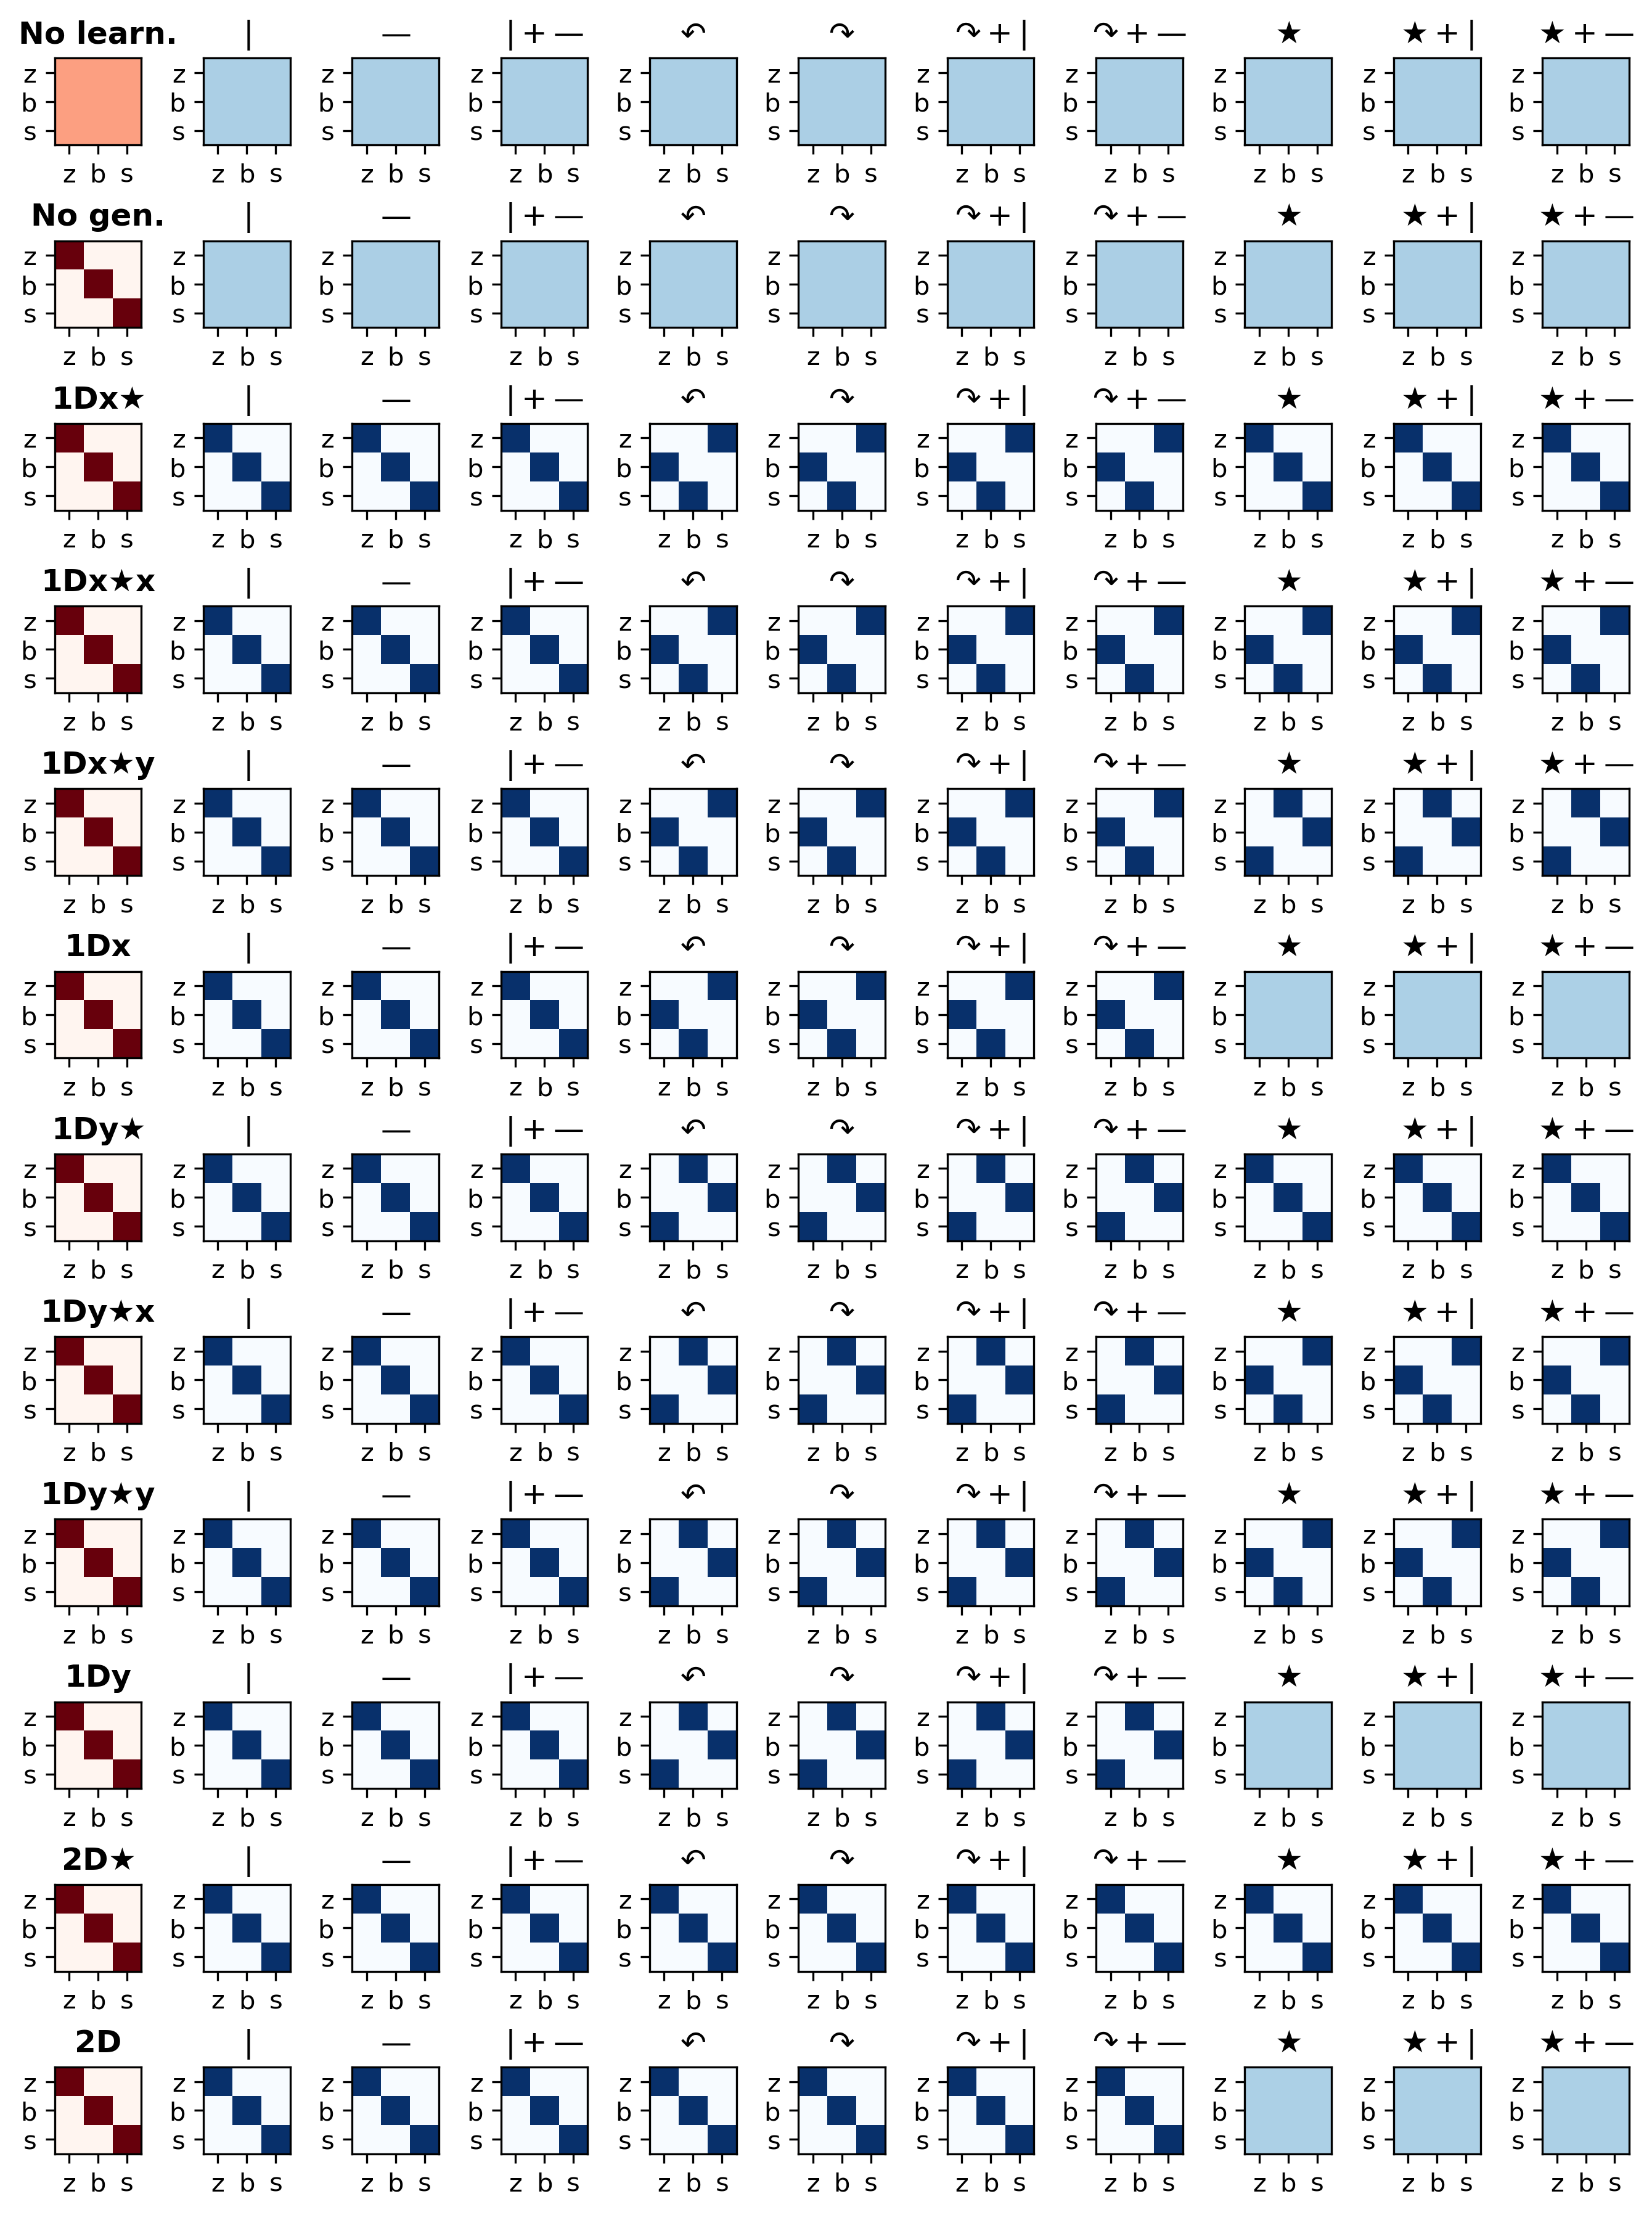

In [23]:
# Prepare figure
fig, AXS = plt.subplots(n_models, n_trial_types, figsize=(9, 1*n_models), dpi=300, facecolor='w')

for i, axs in enumerate(AXS):
    for j, (ax, trial_type) in enumerate(zip(axs, trial_types)):

        # Get colormap
        cmap = bloc_type_cmaps['training'] if trial_type == r'$\emptyset$' else bloc_type_cmaps['generalization']

        # Get confution matrix
        m = CONFUSION_MATRIX_MODELS[i, j]

        # Plot matrix
        ax.imshow(m, vmin=0, vmax=1, cmap=cmap)
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(labels_names)
        ax.set_yticklabels(labels_names)
        ax.set_title(trial_type, fontweight='bold')
        
    # Name of the model
    axs[0].set_title(model_names[i], fontweight='bold')

plt.tight_layout()
fig.savefig('figures/fig_2.png')

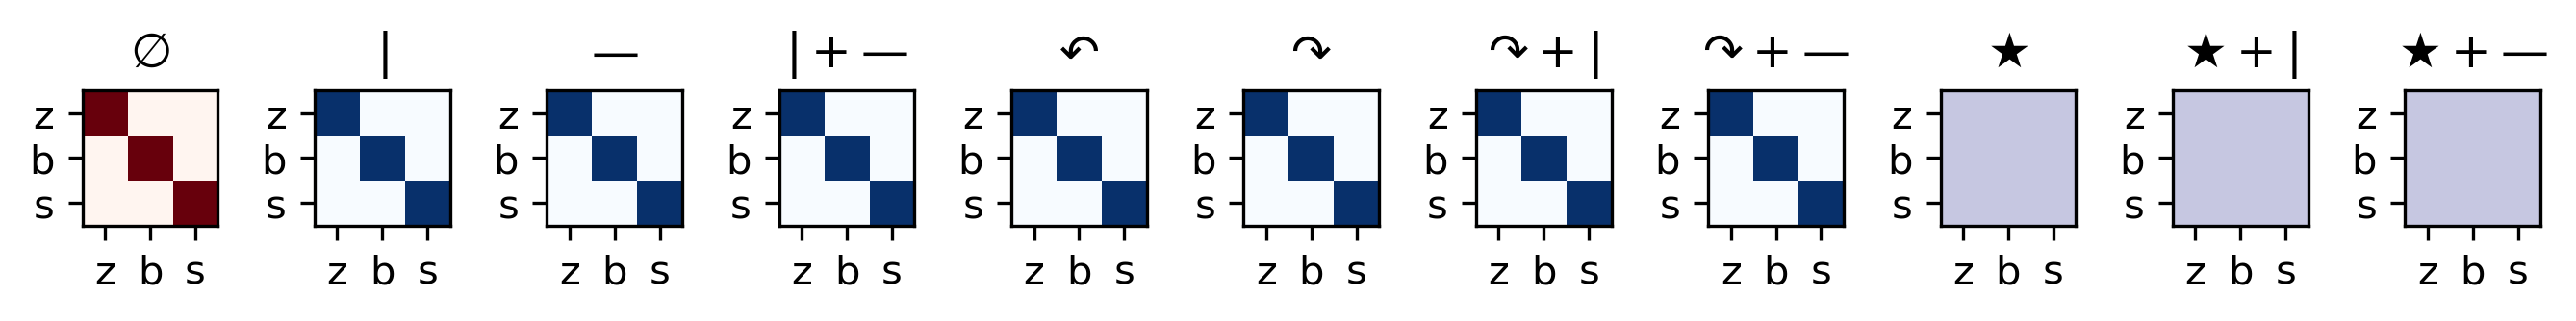

In [24]:
# Prepare figure
fig, AXS = plt.subplots(1, n_trial_types, figsize=(9, 1), dpi=300, facecolor='w')
AXS = np.atleast_2d(AXS)
i_model = -1

for i, axs in enumerate(AXS):
    for j, (ax, trial_type) in enumerate(zip(axs, trial_types)):

        # Get colormap
        cmap = bloc_type_cmaps['training'] if trial_type == r'$\emptyset$' else bloc_type_cmaps['generalization']
        if trial_type in (r'$\bigstar$', r'$\bigstar + |$', r'$\bigstar + —$'): 
            cmap = matplotlib.cm.get_cmap('Purples')
        
        # Get confution matrix
        m = CONFUSION_MATRIX_MODELS[i_model, j]

        # Plot matrix
        ax.imshow(m, vmin=0, vmax=1, cmap=cmap)
        ax.set_xticks(range(3))
        ax.set_yticks(range(3))
        ax.set_xticklabels(labels_names)
        ax.set_yticklabels(labels_names)
        ax.set_title(trial_type, fontweight='bold')

plt.tight_layout()
fig.savefig('figures/fig_2b.png')

In [25]:
# Save model
dname = os.getcwd() + '/../../data/'
np.save(dname + 'CONFUSION_MATRIX_MODELS', CONFUSION_MATRIX_MODELS)